## CSCI 5654 - Linear Programming - Project

***
#### Team Members
#### 1. Ketan Ramesh
#### 2. Shreyas Gopalakrishna
***

## Vehicle Routing Problem

In [1]:
!pip3 install pulp

     |████████████████████████████████| 40.6MB 71kB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
import pulp

## Capacity Vehicle Routing Problem - Model 2

Paper Link - [Integer linear programming formulation for a vehicle routing problem](https://doi.org/10.1016/0377-2217(91)90338-V)

<div align="justify">
The code provided below creates a <code>class</code> to frame and solve the Capacity Vehicle Routing Problem (CVRP) using a Vehicle Path variant of the <b>Kulkarni-Bhave formulation</b> as mentioned in the paper. The problem as a Mixed ILP is as follows:
</div>

$$
min \sum_{(i, j) \in A} c_{ij} x_{ij}
$$

$$
\sum_{i=1, i \neq j}^{N} x_{ij} = 1, j=1, ..., N-1, - (2.1)
$$

$$
\sum_{j=1, j \neq i}^{N-1} x_{ij} +x_{iN^{'}} = 1, j=1, ..., N-1, - (2.2)
$$

$$
\sum_{j=1}^{N-1} x_{Nj} = V, - (2.3)
$$

$$
\sum_{i=1}^{N-1} x_{iN^{'}} = V, - (2.4)
$$

$$
y_i - y_j +(L+1)x_{ij} \leq L, \forall (i, j) \in A, - (2.5)
$$

$$
y_{N^{'}} - y_N \leq L, \forall (i, j) \in A, - (2.6)
$$

$$
u_i - u_j + Wx_{ij} \leq W - Q_j, \forall (i, j) \in A, - (2.7)
$$

$$
u_{N^{'}} - u_N = W,  - (2.8)
$$

$$
v_i - v_j + (c_{ij} + T) x_{ij} \leq T, \forall (i, j) \in A, - (2.9)
$$

$$
v_{N^{'}} - v_N = T,  - (2.10)
$$

$$
x_{ij} = \{0, 1\} , \forall (i, j) \in A
$$

where,

N - 1 customer locations are denoted as 1, 2, ..., N - 1. The location of depot is denoted by N.<br />
Q<sub>j</sub> = Demand of customer at location j.<br />
V = Number of delivery vehicles.<br />
L = Number of customers that a vehicle can service in a route (preset).<br />
T = Maximum distance that any route can reach (preset).<br />
W = Capacity of the vehicle.<br />
c<sub>ij</sub> = Cost incurred on traveling from i to j.<br />
Depot = N, N<sup>'</sup><br />

$$
A = \{(N, i), (i, j), (i, N^{'}) : 1 \leq i \neq j \leq N - 1\},
$$

<b>Decision Variables:</b>
1. x<sub>ij</sub> = {<b>1</b>, if edge (i, j) present in any route. <b>0</b>, otherwise}. 

2. y<sub>ij</sub>, u<sub>ij</sub> and v<sub>ij</sub> = A set of continuous non-negative variables.

<div align="justify">
The objective is to minimize the sum of the distances of all routes that satisfy the given constraints. The constraint (2, 1) ensures that all customer nodes are visited by exactly once while the constraint (2, 2) ensures that the number of paths arising from a node is exactly one (prevents multiple visits to the same node). The constraints (2, 3). and (2, 4) add the requirement that all vehicles be used for routing. The constraints (2, 5) and (2, 6) are used to eliminate sub tours in the problem. The constraints (2, 7) and (2, 8) ensure that the cumulative load on the route doesn't exceed the vehicle capacity. The constraints (2, 9) and (2, 10) ensure that each vehicle route doesn't exceed a set distance.
</div>

In [0]:
class CVRP2:
    def __init__(self, numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix, A, L, T):
        self.numberOfCustomers = numberOfCustomers
        self.numberOfVehicles  = numberOfVehicles
        self.capacityOfVehicle = capacityOfVehicle
        self.demandOfCustomers = demandOfCustomers
        self.costMatrix        = costMatrix
        self.A = A
        self.L = L
        self.T = T
        self.N = len(self.costMatrix)
        self.initializeLP()

    def initializeLP(self):
        self.cvrpLP = pulp.LpProblem("CVRP", pulp.LpMinimize)
        objective = None
        x, y = [], []
        u, v = [], []

        # Decision Variables
        for i in range(self.N):
          xRow = []
          y.append(pulp.LpVariable('y('+str(i)+')', lowBound=0, cat='Continuous'))
          u.append(pulp.LpVariable('u('+str(i)+')', lowBound=0, cat='Continuous'))
          v.append(pulp.LpVariable('v('+str(i)+')', lowBound=0, cat='Continuous'))
          for j in range(self.N):
            xRow.append(pulp.LpVariable('x('+str(i)+','+str(j)+')', cat='Binary'))
          x.append(xRow)

        # Adding objective
        for tup in self.A:
          objective += costMatrix[tup[0]][tup[1]] * x[tup[0]][tup[1]]
        self.cvrpLP += objective

        # Adding constraint 1
        for j in range(1, self.N - 1):
          constraint1 = None
          for i in range(1, self.N):
            if (i != j):
              constraint1 += x[i][j]
          self.cvrpLP += constraint1 == 1

        # Adding constraint 2
        for i in range(1, self.N - 1):
          constraint2 = None
          for j in range(1, self.N - 1):
            if (i != j):
              constraint2 += x[i][j]
          constraint2 += x[i][self.N - 1]
          self.cvrpLP += constraint2 == 1

        # Adding constraint 3
        constraint3 = None
        for i in range(1, self.N - 1):
          constraint3 += x[0][i]
        self.cvrpLP += constraint3 == self.numberOfVehicles

        # Adding constraint 4
        constraint4 = None
        for i in range(1, self.N - 1):
          constraint4 += x[i][self.N - 1]
        self.cvrpLP += constraint4 == self.numberOfVehicles

        # Adding constraint 5
        for tup in self.A:
          self.cvrpLP += y[tup[0]] - y[tup[1]] + (self.L + 1) * x[tup[0]][tup[1]] <= self.L

        # Adding constraint 6
        self.cvrpLP += y[-1] - y[0] <= self.L + 1

        # Adding constraint 7
        for i, j in self.A:
          self.cvrpLP += u[i] - u[j] + self.capacityOfVehicle * x[i][j] <= self.capacityOfVehicle - self.demandOfCustomers[j]

        # Adding constraint 8
        self.cvrpLP += u[-1] - u[0] == self.capacityOfVehicle

        # Adding constraint 9
        for i, j in self.A:
          self.cvrpLP += v[i] - v[j] + (self.costMatrix[i][j] + self.T) * x[i][j] <= self.T
        
        # Adding constrint 10
        self.cvrpLP += v[-1] - v[0] == self.T

        # Adding flow constraint
        for h in range(1, len(costMatrix)-1):
            constraint5a, constraint5b = None, None
            for i in range(0, len(costMatrix)-1):
                if(i != h):
                    constraint5a += x[i][h]
            for j in range(1, len(costMatrix)):
                if(j != h):
                    constraint5b += x[h][j]
            self.cvrpLP += constraint5a - constraint5b == 0

    def solve(self):
        status = self.cvrpLP.solve()
        print(pulp.LpStatus[self.cvrpLP.status])
    
    def getResult(self):
        print("Objective value: ", pulp.value(self.cvrpLP.objective))
        for v in self.cvrpLP.variables():
            print(v.name, " = ", v.varValue)
        return self.cvrpLP

## Random Testing

In [27]:
numberOfCustomers = 5
capacityOfVehicle = 10
numberOfVehicles = 3
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {1: 1, 2: 5, 3: 8, 4: 5, 5: 5, 6: 0, 0: 0}
# demandOfCustomers[0] = 0
# demandOfCustomers[numberOfCustomers+1] = 0

# Creating random coordinates
xCoordinates = [30, 20, 10, 10, 40, 50, 30]
yCoordinates = [30, 40, 45, 30, 10, 30, 30]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
costMatrix

array([[ 0., 14., 25., 20., 22., 20.,  0.],
       [14.,  0., 11., 14., 36., 31., 14.],
       [25., 11.,  0., 15., 46., 42., 25.],
       [20., 14., 15.,  0., 36., 40., 20.],
       [22., 36., 46., 36.,  0., 22., 22.],
       [20., 31., 42., 40., 22.,  0., 20.],
       [ 0., 14., 25., 20., 22., 20.,  0.]])

In [28]:
A = []
L = numberOfCustomers
T = 999999
for i in range(1, len(costMatrix) - 1):
  A.append((0, i))
  for j in range(1, len(costMatrix) - 1):
    if (i != j):
      A.append((i, j))
  A.append((i, len(costMatrix) - 1))
print(len(A))

30


In [0]:
cvrp = CVRP2(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix, A, L, T)

In [30]:
cvrp.solve()
result = cvrp.getResult()

Optimal
Objective value:  141.0
u(0)  =  0.0
u(1)  =  8.0
u(2)  =  7.0
u(3)  =  8.0
u(4)  =  3.0
u(5)  =  8.0
u(6)  =  10.0
v(0)  =  0.0
v(1)  =  14.0
v(2)  =  0.0
v(3)  =  20.0
v(4)  =  0.0
v(5)  =  22.0
v(6)  =  999999.0
x(0,1)  =  1.0
x(0,2)  =  0.0
x(0,3)  =  1.0
x(0,4)  =  0.0
x(0,5)  =  1.0
x(1,2)  =  0.0
x(1,3)  =  0.0
x(1,4)  =  0.0
x(1,5)  =  0.0
x(1,6)  =  1.0
x(2,1)  =  1.0
x(2,3)  =  0.0
x(2,4)  =  0.0
x(2,5)  =  0.0
x(2,6)  =  0.0
x(3,1)  =  0.0
x(3,2)  =  0.0
x(3,4)  =  0.0
x(3,5)  =  0.0
x(3,6)  =  1.0
x(4,1)  =  0.0
x(4,2)  =  0.0
x(4,3)  =  0.0
x(4,5)  =  1.0
x(4,6)  =  0.0
x(5,1)  =  0.0
x(5,2)  =  0.0
x(5,3)  =  0.0
x(5,4)  =  0.0
x(5,6)  =  1.0
x(6,1)  =  0.0
x(6,2)  =  1.0
x(6,3)  =  1.0
x(6,4)  =  1.0
x(6,5)  =  0.0
y(0)  =  0.0
y(1)  =  1.0
y(2)  =  0.0
y(3)  =  1.0
y(4)  =  0.0
y(5)  =  1.0
y(6)  =  2.0


In [20]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.variables():
    if('x' in v.name and v.varValue == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.name.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X, c):
    if start in c:
        return X
    for item in L:
        if(item[0] == start):
            X.append(item)
            c.append(start)
            return recursiveList(item[1], L, X, c)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v], [v[0]])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        setList.append(list(set(set1)))

[(0, 1), (0, 3), (0, 4), (1, 2), (2, 6), (3, 6), (4, 5), (5, 6), (6, 1), (6, 3), (6, 4)]
[(0, 1), (1, 2), (2, 6), (6, 1)]
[(0, 3), (3, 6), (6, 1), (1, 2), (2, 6)]
[(0, 4), (4, 5), (5, 6), (6, 1), (1, 2), (2, 6)]


In [0]:
xCoordinates = [30, 20, 10, 10, 40, 50, 35]
yCoordinates = [30, 40, 45, 30, 10, 30, 35]

coordinateList = []
for s in variables:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList[0])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value

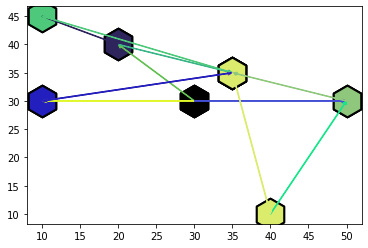

In [78]:
def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
    
    # ax.arrow(L[-1][0],  #x1
    #                 L[-1][1],  # y1
    #                 L[0][0]-L[-1][0], # x2 - x1
    #                 L[0][1]-L[-1][1], # y2 - y1
    #                 width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
    #                 )
for i in range(len(coordinateList)):
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()



## N-15 Testing

In [0]:
numberOfCustomers = 15
capacityOfVehicle = 35
numberOfVehicles = 8
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {0:0,1:19,2:30,3:16,4:23,5:11,6:31,7:15,8:28,9:8,10:8,11:7,12:14,13:6,14:19,15:11}
# demandOfCustomers[0] = 0
demandOfCustomers[numberOfCustomers+1] = 0

In [0]:
xCoordinates = [30,37,49,52,31,52,42,52,57,62,42,27,43,58,58,37,30]
yCoordinates = [40,52,49,64,62,33,41,41,58,42,57,68,67,48,27,69,40]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 999999

In [38]:
A = []
L = numberOfCustomers
T = 999999
for i in range(1, len(costMatrix) - 1):
  A.append((0, i))
  for j in range(1, len(costMatrix) - 1):
    if (i != j):
      A.append((i, j))
  A.append((i, len(costMatrix) - 1))
print(len(A))

240


In [0]:
cvrp2 = CVRP2(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix, A, L, T)

In [40]:
cvrp2.solve()
result = cvrp2.getResult()

Optimal
Objective value:  444.0
u(0)  =  0.0
u(1)  =  19.0
u(10)  =  8.0
u(11)  =  7.0
u(12)  =  22.0
u(13)  =  6.0
u(14)  =  35.0
u(15)  =  33.0
u(16)  =  35.0
u(2)  =  30.0
u(3)  =  35.0
u(4)  =  30.0
u(5)  =  11.0
u(6)  =  31.0
u(7)  =  15.0
u(8)  =  35.0
u(9)  =  19.0
v(0)  =  0.0
v(1)  =  13.0
v(10)  =  20.0
v(11)  =  28.0
v(12)  =  30.0
v(13)  =  29.0
v(14)  =  37.0
v(15)  =  36.0
v(16)  =  999999.0
v(2)  =  21.0
v(3)  =  60.0
v(4)  =  35.0
v(5)  =  23.0
v(6)  =  12.0
v(7)  =  22.0
v(8)  =  39.0
v(9)  =  36.0
x(0,1)  =  1.0
x(0,10)  =  1.0
x(0,11)  =  1.0
x(0,12)  =  0.0
x(0,13)  =  1.0
x(0,14)  =  0.0
x(0,15)  =  0.0
x(0,2)  =  1.0
x(0,3)  =  0.0
x(0,4)  =  0.0
x(0,5)  =  1.0
x(0,6)  =  1.0
x(0,7)  =  1.0
x(0,8)  =  0.0
x(0,9)  =  0.0
x(1,10)  =  0.0
x(1,11)  =  0.0
x(1,12)  =  0.0
x(1,13)  =  0.0
x(1,14)  =  0.0
x(1,15)  =  0.0
x(1,16)  =  1.0
x(1,2)  =  0.0
x(1,3)  =  0.0
x(1,4)  =  0.0
x(1,5)  =  0.0
x(1,6)  =  0.0
x(1,7)  =  0.0
x(1,8)  =  0.0
x(1,9)  =  0.0
x(10,1)  =  0.0


## N-31 Testing

In [0]:
numberOfCustomers = 31
capacityOfVehicle = 100
numberOfVehicles = 5
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {0:0,1:19,2:21,3:6,4:19,5:7,6:12,7:16,8:6,9:16,10:8,11:14,12:21,13:16,14:3,15:22,16:18,17:19,18:1,19:24,20:8,21:12,22:4,23:8,24:24,25:24,26:2,27:20,28:15,29:2,30:14,31:9}
# demandOfCustomers[0] = 0
demandOfCustomers[numberOfCustomers+1] = 0

In [0]:
xCoordinates = [82,96,50,49,13,29,58,84,14,2,3,5,98,84,61,1,88,91,19,93,50,98,5,42,61,9,80,57,23,20,85,98,82]
yCoordinates = [76,44,5,8,7,89,30,39,24,39,82,10,52,25,59,65,51,2,32,3,93,14,42,9,62,97,55,69,15,70,60,5,76]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 999999

In [43]:
A = []
L = numberOfCustomers
T = 999999
for i in range(1, len(costMatrix) - 1):
  A.append((0, i))
  for j in range(1, len(costMatrix) - 1):
    if (i != j):
      A.append((i, j))
  A.append((i, len(costMatrix) - 1))
print(len(A))

992


In [0]:
cvrp2 = CVRP2(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix, A, L, T)

In [45]:
cvrp2.solve()
result = cvrp2.getResult()

KeyboardInterrupt: ignored